# Data loader with old imgz

/tmp/ipykernel_17592/3683362262.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


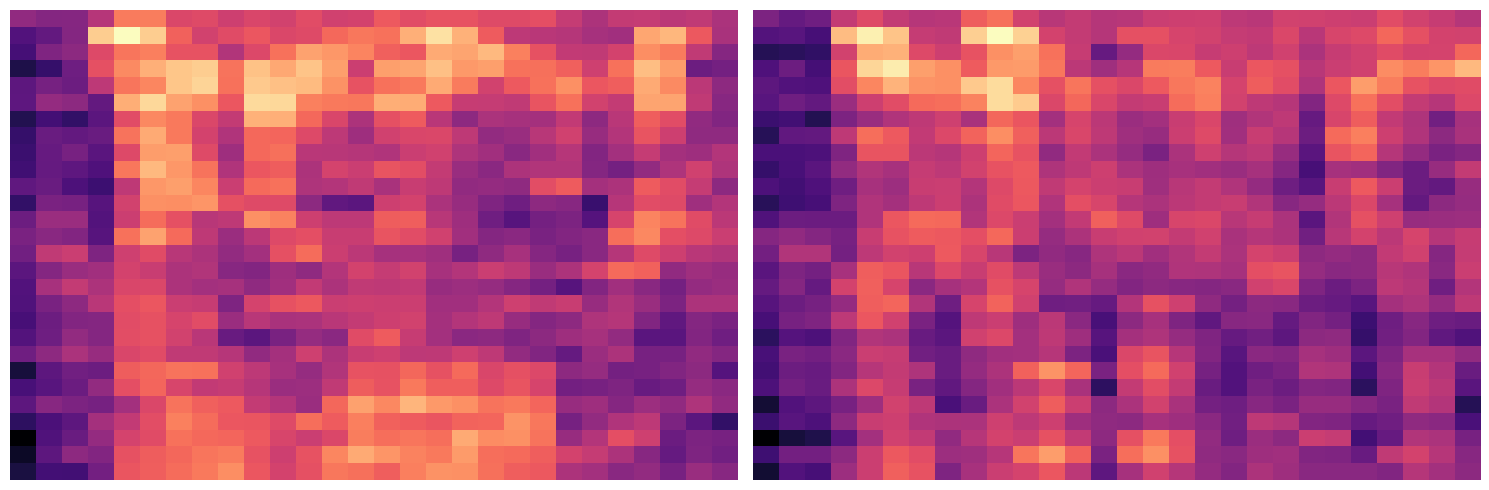

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
import glob

class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, target_size=(28, 28)):
        """
        Dataset class to load Mel spectrogram tensors.
        Args:
            root_dir (str): Path to the directory containing preprocessed Mel spectrogram tensors.
            target_size (tuple): Desired size of the Mel spectrogram (height, width).
        """
        self.root_dir = root_dir
        self.files = glob.glob(os.path.join(root_dir, "mel_*.pt"))
        self.target_size = target_size

        if not self.files:
            raise ValueError(f"No Mel spectrogram files found in directory: {root_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        Load a Mel spectrogram tensor, resize it to the target size, and return it.
        Args:
            idx (int): Index of the sample to load.
        Returns:
            torch.Tensor: Resized Mel spectrogram tensor.
        """
        file_path = self.files[idx]
        data = torch.load(file_path)

        mel_spec = data['mel_spec_db_norm']  # Normalized Mel spectrogram

        # Resize to the target size
        mel_spec_resized = torch.nn.functional.interpolate(
            mel_spec.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
            size=self.target_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(0).squeeze(0)  # Remove batch and channel dimensions

        return mel_spec_resized

# Directory where Mel spectrogram tensors are stored
mel_spectrogram_dir = "output_mel_spectrograms"

# Create the dataset
mel_dataset = MelSpectrogramDataset(mel_spectrogram_dir, target_size=(28, 28))

# Create the DataLoader
batch_size = 64
mel_loader = DataLoader(mel_dataset, batch_size=batch_size, shuffle=True)

# Visualize a few samples
import matplotlib.pyplot as plt

def visualize_mel_spectrograms(data_loader, num_samples=8):
    """
    Visualize a batch of Mel spectrograms from the DataLoader.
    Args:
        data_loader (DataLoader): DataLoader for the dataset.
        num_samples (int): Number of samples to visualize.
    """
    batch = next(iter(data_loader))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(min(num_samples, batch_size)):
        mel_spec = batch[i].numpy()
        axes[i].imshow(mel_spec, cmap='magma', aspect='auto')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a batch of spectrograms
visualize_mel_spectrograms(mel_loader, num_samples=2)


# Attemp1

In [9]:

from torch.utils.data import Dataset, DataLoader
import torch
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os


class MelSpectrogramDataset(Dataset):
    def __init__(self, mel_spectrogram_dir):
        self.mel_spectrogram_files = glob.glob(os.path.join(mel_spectrogram_dir, 'mel_*.pt'))
        self.mel_spectrogram_files.sort()  # Ensure consistent order

    def __len__(self):
        return len(self.mel_spectrogram_files)

    def __getitem__(self, idx):
        mel_spec_file = self.mel_spectrogram_files[idx]
        data = torch.load(mel_spec_file)
        mel_spec_db_norm = data['mel_spec_db_norm']  # Shape: (n_mels, target_length)
        # Add a channel dimension to match (1, n_mels, target_length)
        mel_spec_db_norm = mel_spec_db_norm.unsqueeze(0)
        return mel_spec_db_norm

# Usage in your training code:

# Set the path to your Mel spectrogram tensors
mel_spectrogram_dir = 'output_mel_spectrograms'

# Create the dataset and data loader
mel_dataset = MelSpectrogramDataset(mel_spectrogram_dir=mel_spectrogram_dir)
train_loader = DataLoader(mel_dataset, batch_size=batch_size, shuffle=True)


In [10]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 512 * 16 * 8)
        self.gen = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16x8 -> 32x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x16 -> 64x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64x32 -> 128x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 128x64 -> 256x128
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # 256x128 -> 512x256
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),     # 512x256 -> 1024x512
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x).view(-1, 512, 16, 8)
        x = self.gen(x)
        # Since the output is 1024x512, you may need to crop or interpolate to 1024x256
        x = F.interpolate(x, size=(1024, 256), mode='bilinear', align_corners=False)
        return x


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),   # 1024x256 -> 512x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 512x128 -> 256x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 256x64 -> 128x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 128x32 -> 64x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# 64x16 -> 32x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),# 32x8 -> 16x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(512 * 16 * 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.disc(x)
        x = x.view(-1, 512 * 16 * 4)
        x = self.fc(x)
        return self.sigmoid(x)


In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Add more layers as needed
        )
        self.fc = nn.Linear(16 * (input_height // 2) * (input_width // 2), 64)

    def forward(self, x):
        x = self.enc(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [13]:
def visualize_generated_mel_spectrograms(generators, z_dim, num_images, device):
    noise = generate_noise(num_images, z_dim, device)
    for idx, gen in enumerate(generators):
        fake_mel_specs = gen(noise).detach().cpu().numpy()
        for i in range(num_images):
            mel_spec = fake_mel_specs[i][0]  # Remove batch and channel dimensions
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(
                mel_spec,
                x_axis='time',
                y_axis='mel',
                sr=16000,
                hop_length=256,
                fmax=8000
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Generator {idx + 1} - Generated Mel Spectrogram {i+1}')
            plt.tight_layout()
            plt.show()


In [14]:
def reconstruct_and_save_audio(mel_spectrogram, output_path, target_sr=16000, n_fft=8192, hop_length=256):
    mel_spec_db = (mel_spectrogram + 1) / 2 * (-80) + (-80)  # De-normalize
    mel_spec_power = librosa.db_to_power(mel_spec_db)

    audio = librosa.feature.inverse.mel_to_audio(
        mel_spec_power,
        sr=target_sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=500,
        power=1.0,
    )

    sf.write(output_path, audio, target_sr)
    print(f"Audio saved to {output_path}")


/tmp/ipykernel_17592/4154791750.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(mel_spec_file)


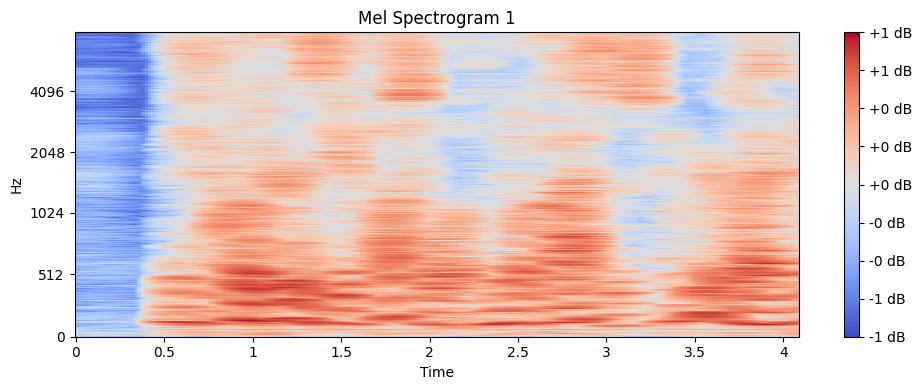

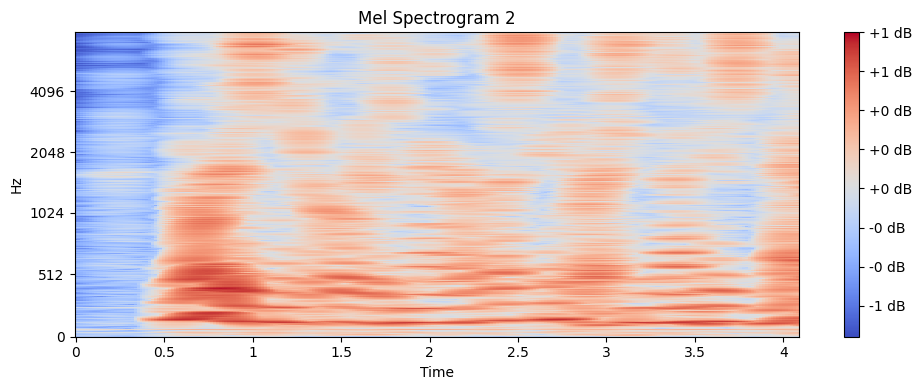

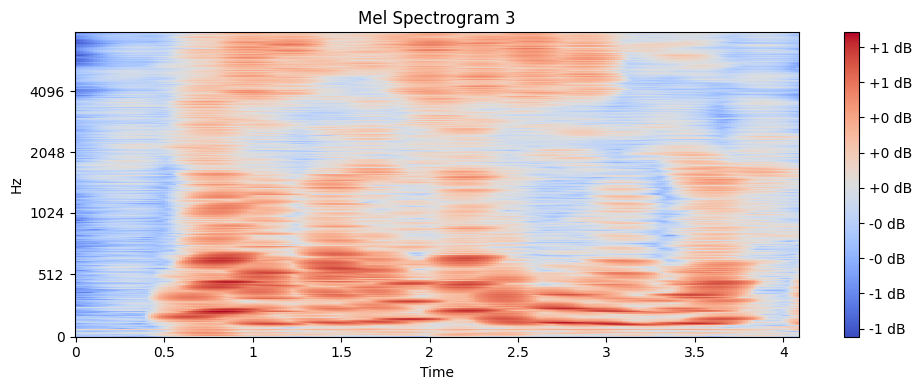

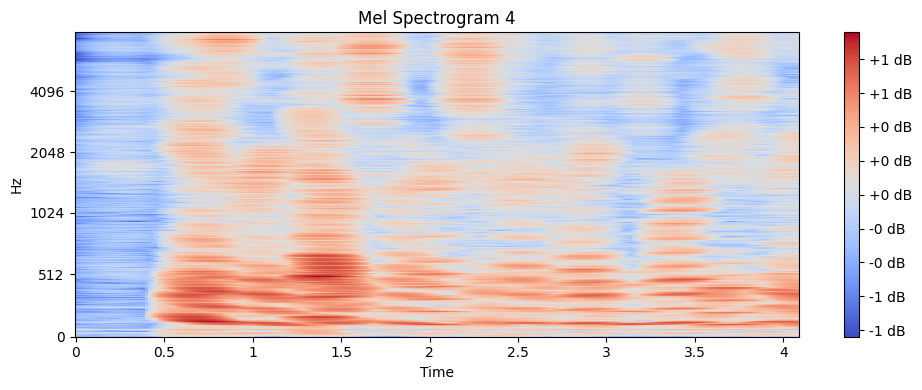

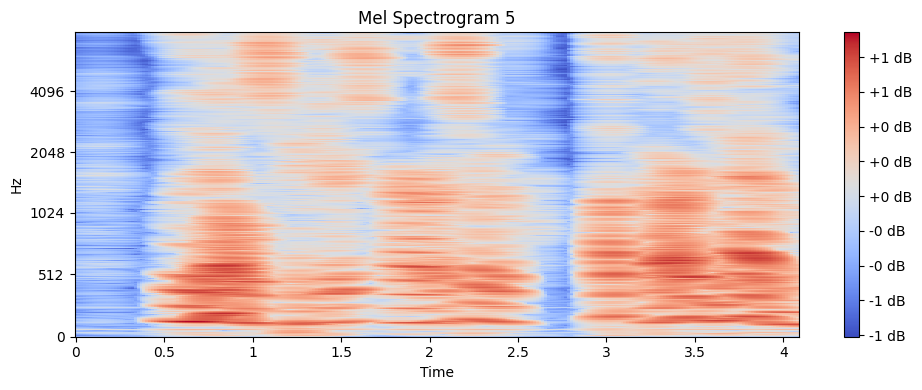

In [15]:
import matplotlib.pyplot as plt
import librosa.display

# Assuming MelSpectrogramDataset is defined
# Define the directory where Mel spectrogram tensors are saved
mel_spectrogram_dir = 'output_mel_spectrograms'

# Create the dataset and data loader
mel_dataset = MelSpectrogramDataset(mel_spectrogram_dir=mel_spectrogram_dir)

# Function to visualize Mel spectrograms
def visualize_loaded_data(dataset, num_samples=5, sr=16000, hop_length=256, fmax=8000):
    """
    Visualizes Mel spectrograms from the dataset.
    
    Args:
    - dataset: The MelSpectrogramDataset instance.
    - num_samples: Number of samples to visualize.
    - sr: Sampling rate for the spectrogram.
    - hop_length: Hop length used in the Mel spectrogram generation.
    - fmax: Maximum frequency for the Mel spectrogram.
    """
    for i in range(min(num_samples, len(dataset))):
        mel_spec = dataset[i][0].squeeze(0).numpy()  # Remove channel dimension
        
        # Plot the Mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            mel_spec,
            x_axis='time',
            y_axis='mel',
            sr=sr,
            hop_length=hop_length,
            fmax=fmax
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram {i+1}')
        plt.tight_layout()
        plt.show()

# Visualize the first 5 samples
visualize_loaded_data(mel_dataset, num_samples=5)


# Attemp3

In [16]:
import os
import glob
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
import torchvision.utils as vutils


# Custom Dataset for Mel Spectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, 
                 target_sr=16000, 
                 fragment_duration=1.0,  # Duration of each audio fragment in seconds
                 n_fft=2048, 
                 hop_length=512, 
                 n_mels=128,
                 max_len=128,  # Maximum length of the Mel spectrogram in frames
                 transform=None):
        """
        Args:
            root_dir (string): Directory with all the audio files.
            target_sr (int): Target sampling rate.
            fragment_duration (float): Duration of each audio fragment in seconds.
            n_fft (int): Number of FFT components.
            hop_length (int): Number of samples between successive frames.
            n_mels (int): Number of Mel bands.
            max_len (int): Maximum length of the Mel spectrogram in frames.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.target_sr = target_sr
        self.fragment_duration = fragment_duration
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.max_len = max_len
        self.transform = transform
        
        self.audio_fragments = []  # List to store tuples of (file_path, start_sample, end_sample)
        
        self._preprocess()
        
    def _preprocess(self):
        # Traverse the directory for audio files
        audio_files = glob.glob(os.path.join(self.root_dir, '**', '*.wav'), recursive=True)
        if len(audio_files) == 0:
            raise ValueError(f"No audio files found in directory: {self.root_dir}")
        print(f"Found {len(audio_files)} audio files.")
        
        total_fragments = 0
        for file_path in audio_files:
            # Load the audio file
            y, sr = librosa.load(file_path, sr=self.target_sr)
            total_samples = y.shape[0]
            fragment_samples = int(self.fragment_duration * sr)
            
            if total_samples < fragment_samples:
                # Audio clip is shorter than desired duration, discard
                continue
            else:
                # Calculate number of full fragments we can get from this audio
                num_fragments = total_samples // fragment_samples
                for i in range(num_fragments):
                    start_sample = i * fragment_samples
                    end_sample = start_sample + fragment_samples
                    self.audio_fragments.append((file_path, start_sample, end_sample))
                    total_fragments += 1
                # If there are leftover samples, create a fragment with the leftover
                leftover_samples = total_samples % fragment_samples
                if leftover_samples >= fragment_samples:
                    start_sample = num_fragments * fragment_samples
                    end_sample = start_sample + fragment_samples
                    self.audio_fragments.append((file_path, start_sample, end_sample))
                    total_fragments += 1
                # Else discard the leftover
        print(f"Total number of fragments: {total_fragments}")
    
    def __len__(self):
        return len(self.audio_fragments)
    
    def __getitem__(self, idx):
        file_path, start_sample, end_sample = self.audio_fragments[idx]
        # Load the audio fragment
        y, sr = librosa.load(file_path, sr=self.target_sr, offset=start_sample / sr, duration=(end_sample - start_sample) / sr)
        
        # Convert to Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, 
                                                  sr=sr, 
                                                  n_fft=self.n_fft, 
                                                  hop_length=self.hop_length, 
                                                  n_mels=self.n_mels, 
                                                  power=1.0)
        # Convert to log scale (dB)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize to [0, 1]
        mel_spec_db_norm = (mel_spec_db + 80) / 80  # Assuming min dB is -80
        
        # Ensure the Mel spectrogram has a fixed length
        if mel_spec_db_norm.shape[1] < self.max_len:
            pad_width = self.max_len - mel_spec_db_norm.shape[1]
            mel_spec_db_norm = np.pad(mel_spec_db_norm, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db_norm = mel_spec_db_norm[:, :self.max_len]
        
        # Convert to tensor
        mel_spec_tensor = torch.tensor(mel_spec_db_norm, dtype=torch.float32)
        mel_spec_tensor = mel_spec_tensor.unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)
        
        return mel_spec_tensor

# Example usage
def visualize_mel_spectrograms(dataset, num_samples=5):
    for i in range(num_samples):
        mel_spec_tensor = dataset[i]
        mel_spec = mel_spec_tensor.squeeze(0).numpy()
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec, sr=dataset.target_sr, hop_length=dataset.hop_length, y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        plt.show()

def print_data_stats(dataset):
    all_specs = []
    for i in range(len(dataset)):
        mel_spec_tensor = dataset[i]
        all_specs.append(mel_spec_tensor.numpy())
    all_specs = np.concatenate(all_specs, axis=0)
    print(f"Data stats - Min: {all_specs.min()}, Max: {all_specs.max()}, Mean: {all_specs.mean()}, Std: {all_specs.std()}")
    print(f"Total number of samples: {len(dataset)}")

# Adjust the model to accept input of size (1, n_mels, max_len)
# Assuming n_mels=128, max_len=128

# Adjust the Generator and Discriminator models
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels=1, feature_map_size=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * feature_map_size * feature_map_size),
            nn.Tanh()
        )
        self.feature_map_size = feature_map_size
        self.img_channels = img_channels

    def forward(self, x):
        return self.gen(x).view(-1, self.img_channels, self.feature_map_size, self.feature_map_size)

class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_map_size=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels * feature_map_size * feature_map_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        self.feature_map_size = feature_map_size
        self.img_channels = img_channels

    def forward(self, x):
        return self.disc(x.view(-1, self.img_channels * self.feature_map_size * self.feature_map_size))

class Encoder(nn.Module):
    def __init__(self, img_channels=1, feature_map_size=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_channels * feature_map_size * feature_map_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128)
        )
        self.feature_map_size = feature_map_size
        self.img_channels = img_channels

    def forward(self, x):
        return self.encoder(x.view(-1, self.img_channels * self.feature_map_size * self.feature_map_size))

# Now, replace the MNIST data loader in the training functions with the MelSpectrogramDataset
# Modify the training functions accordingly

# Assuming we have the training functions defined as in your code,
# we can use the new dataset

# Example of using the dataset and integrating it into the training code

def pretrain_single_generator(num_epochs, z_dim, lr, batch_size, seed, dataset):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the single generator and discriminator
    generator = Generator(z_dim, img_channels=1, feature_map_size=dataset.n_mels).to(device)
    discriminator = Discriminator(img_channels=1, feature_map_size=dataset.n_mels).to(device)

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # Create DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Training loop
    for epoch in range(num_epochs):
        loss_disc_epoch = 0
        loss_gen_epoch = 0

        for batch_idx, real in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)

            # Train Discriminator
            noise = generate_noise(batch_size, z_dim, device)
            fake = generator(noise)

            disc_real = discriminator(real).view(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

            disc_fake = discriminator(fake.detach()).view(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()

            # Train Generator
            output = discriminator(fake).view(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()

            loss_disc_epoch += loss_disc.item()
            loss_gen_epoch += loss_gen.item()

        print(f"Pretrain Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_disc_epoch/len(train_loader):.4f}, Loss G: {loss_gen_epoch/len(train_loader):.4f}")

    # Visualize the generated images after pretraining
    visualize_generated_images([generator], z_dim, num_images=16, device=device)

    return generator

def main():
    data_dir = "data/LibriSpeech/LibriSpeech/dev-clean"  # Replace with your directory
    dataset = MelSpectrogramDataset(root_dir=data_dir, 
                                    target_sr=16000, 
                                    fragment_duration=1.0, 
                                    n_fft=2048, 
                                    hop_length=512, 
                                    n_mels=128, 
                                    max_len=128)

    print_data_stats(dataset)
    visualize_mel_spectrograms(dataset, num_samples=5)

    # # Pretrain a single generator
    # pretrained_generator = pretrain_single_generator(num_epochs=20, 
    #                                                  z_dim=100, 
    #                                                  lr=0.0002, 
    #                                                  batch_size=64, 
    #                                                  seed=42, 
    #                                                  dataset=dataset)
    # Continue training with multiple generators
    # ... (adjust the training functions to use the new dataset and models)

if __name__ == "__main__":
    main()


ValueError: No audio files found in directory: data/LibriSpeech/LibriSpeech/dev-clean

# Attemp4 (Working DATA loader)



In [1]:
import os
import glob
import librosa
import librosa.display
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import soundfile as sf


class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, target_sr=16000, fragment_duration=1.0, 
                 n_fft=2048, hop_length=512, n_mels=128, max_len=128):
        """
        Dataset to handle audio files and convert them to Mel spectrograms.
        Args:
            root_dir: Directory containing audio files (.flac or .wav).
            target_sr: Target sampling rate for audio.
            fragment_duration: Duration (in seconds) for each audio fragment.
            n_fft: Number of FFT components for Mel spectrogram.
            hop_length: Number of samples between successive frames.
            n_mels: Number of Mel bands.
            max_len: Maximum number of frames in Mel spectrograms.
        """
        self.root_dir = root_dir
        self.target_sr = target_sr
        self.fragment_duration = fragment_duration
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.max_len = max_len
        self.audio_fragments = []

        self._load_files()

    def _load_files(self):
        # Gather all audio files (both .flac and .wav)
        audio_files = glob.glob(os.path.join(self.root_dir, "**", "*.flac"), recursive=True)
        audio_files += glob.glob(os.path.join(self.root_dir, "**", "*.wav"), recursive=True)

        if not audio_files:
            raise ValueError(f"No audio files found in directory: {self.root_dir}")

        print(f"Found {len(audio_files)} audio files.")

        fragment_duration = 4  # Desired duration in seconds
        fragment_samples = int(fragment_duration * self.target_sr)

        current_audio = []  # Buffer to hold concatenated audio
        for file_path in audio_files:
            # Load and analyze each file
            y, sr = librosa.load(file_path, sr=self.target_sr)
            total_samples = len(y)

            # Process audio in chunks
            start = 0
            while start < total_samples:
                remaining_samples = total_samples - start
                if len(current_audio) >= fragment_samples:
                    # Save the current fragment if it matches the desired duration
                    self.audio_fragments.append(np.concatenate(current_audio[:fragment_samples]))
                    current_audio = current_audio[fragment_samples:]

                if remaining_samples >= fragment_samples:
                    # Add a full fragment directly
                    self.audio_fragments.append(y[start:start + fragment_samples])
                    start += fragment_samples
                else:
                    # Add the remaining part to the buffer
                    current_audio.append(y[start:])
                    start = total_samples

        # Handle leftover buffer
        if len(current_audio) > 0:
            # Pad to make it a complete fragment if necessary
            concatenated_audio = np.concatenate(current_audio)
            if len(concatenated_audio) < fragment_samples:
                concatenated_audio = np.pad(concatenated_audio, (0, fragment_samples - len(concatenated_audio)))
            self.audio_fragments.append(concatenated_audio)

        print(f"Generated {len(self.audio_fragments)} fragments.")



    def __len__(self):
        return len(self.audio_fragments)

    # def __getitem__(self, idx):
    #     file_path, start_sample, end_sample = self.audio_fragments[idx]
    #     offset_sec = start_sample / self.target_sr
    #     duration_sec = (end_sample - start_sample) / self.target_sr  # Should now always be 4 seconds

    #     # Load the audio fragment
    #     y, sr = librosa.load(file_path, sr=self.target_sr, offset=offset_sec, duration=duration_sec)

    #     # Adjust n_fft dynamically if the signal is shorter than n_fft
    #     effective_n_fft = min(self.n_fft, len(y))

    #     # Generate Mel spectrogram
    #     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=effective_n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
    #     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    #     # Normalize to [0, 1]
    #     mel_spec_db_norm = (mel_spec_db + 80) / 80  # Assuming min dB is -80

    #     # Pad or truncate to fixed length
    #     if mel_spec_db_norm.shape[1] < self.max_len:
    #         pad_width = self.max_len - mel_spec_db_norm.shape[1]
    #         mel_spec_db_norm = np.pad(mel_spec_db_norm, ((0, 0), (0, pad_width)), mode='constant')
    #     else:
    #         mel_spec_db_norm = mel_spec_db_norm[:, :self.max_len]

    #     return torch.tensor(mel_spec_db_norm, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    def __getitem__(self, idx): 
        # Retrieve the concatenated audio fragment
        y = self.audio_fragments[idx]
        
        # Adjust n_fft dynamically if the signal is shorter than n_fft
        effective_n_fft = min(self.n_fft, len(y))

        # Generate Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.target_sr, n_fft=effective_n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize to [0, 1]
        mel_spec_db_norm = (mel_spec_db + 80) / 80  # Assuming min dB is -80

        # Pad or truncate to fixed length
        if mel_spec_db_norm.shape[1] < self.max_len:
            pad_width = self.max_len - mel_spec_db_norm.shape[1]
            mel_spec_db_norm = np.pad(mel_spec_db_norm, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db_norm = mel_spec_db_norm[:, :self.max_len]

        return torch.tensor(mel_spec_db_norm, dtype=torch.float32).unsqueeze(0)  # Add channel dimension




def visualize_mel_spectrogram(dataset, num_samples=5):
    """Visualize some Mel spectrogram samples from the dataset."""
    for i in range(min(num_samples, len(dataset))):
        mel_spec_tensor = dataset[i]
        mel_spec = mel_spec_tensor.squeeze(0).numpy()
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec, sr=dataset.target_sr, hop_length=dataset.hop_length, y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram {i}')
        plt.tight_layout()
        plt.show()


def print_dataset_statistics(dataset):
    """Print dataset statistics such as min, max, mean, and total samples."""
    all_mel_specs = []
    for i in range(len(dataset)):
        mel_spec = dataset[i].squeeze(0).numpy()
        all_mel_specs.append(mel_spec)
    all_mel_specs = np.array(all_mel_specs)
    print(f"Min: {all_mel_specs.min()}, Max: {all_mel_specs.max()}, Mean: {all_mel_specs.mean()}, Std: {all_mel_specs.std()}")
    print(f"Total samples: {len(dataset)}")


def reconstruct_audio_from_mel_spectrograms(output_dir, dataset, target_sr=16000, n_fft=2048, hop_length=512, n_iter=500):
    """
    Reconstruct audio from Mel spectrograms in the dataset and save as WAV files.

    Args:
        output_dir (str): Directory to save the reconstructed audio files.
        dataset (Dataset): The dataset containing Mel spectrograms.
        target_sr (int): Target sampling rate for the audio.
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.
        n_iter (int): Number of iterations for Griffin-Lim phase reconstruction.
    """
    os.makedirs(output_dir, exist_ok=True)

    for i in range(len(dataset)):
        mel_spec_tensor = dataset[i].squeeze(0)  # Remove channel dimension
        mel_spec_db_norm = mel_spec_tensor.numpy()

        # De-normalize Mel spectrogram from [0, 1] back to dB scale
        mel_spec_db = mel_spec_db_norm * 80 - 80  # Assuming min dB is -80

        # Convert dB back to power
        mel_spec_power = librosa.db_to_power(mel_spec_db)

        # Reconstruct audio using Griffin-Lim
        audio = librosa.feature.inverse.mel_to_audio(
            mel_spec_power,
            sr=target_sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_iter=n_iter,
            power=1.0,
        )

        # Save the reconstructed audio to a file
        audio_path = os.path.join(output_dir, f"reconstructed_{i}.wav")
        sf.write(audio_path, audio, target_sr)
        print(f"Reconstructed audio saved to {audio_path}")





In [2]:
def test_transform_back(dataset, output_dir, target_sr=16000, n_fft=2048, hop_length=512, n_iter=500):
    """
    Test the transform-back capability of the dataset by reconstructing audio
    from Mel spectrograms and saving it to a file with RMS normalized to maximum.

    Args:
        dataset: The dataset to test.
        output_dir: Directory to save reconstructed audio files.
        target_sr: Sampling rate of the audio.
        n_fft: Number of FFT components.
        hop_length: Hop length for the Mel spectrogram.
        n_iter: Number of iterations for Griffin-Lim reconstruction.
    """
    os.makedirs(output_dir, exist_ok=True)

    for i in range(min(len(dataset), 5)):  # Test first 5 samples
        # Retrieve the Mel spectrogram
        mel_spec_tensor = dataset[i].squeeze(0)  # Remove channel dimension
        mel_spec_db_norm = mel_spec_tensor.numpy()

        # De-normalize from [0, 1] back to dB scale
        mel_spec_db = mel_spec_db_norm * 80 - 80  # Assuming min dB is -80

        # Convert dB back to power
        mel_spec_power = librosa.db_to_power(mel_spec_db)

        # Reconstruct audio using Griffin-Lim
        audio = librosa.feature.inverse.mel_to_audio(
            mel_spec_power,
            sr=target_sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_iter=n_iter,
            power=1.0,
        )

        # Normalize RMS to maximum
        max_rms = 0.99  # A slight buffer to prevent clipping
        rms = np.sqrt(np.mean(audio**2))
        if rms > 0:  # Prevent division by zero
            audio = audio * (max_rms / rms)

        # Save the reconstructed audio to a file
        audio_path = os.path.join(output_dir, f"reconstructed_{i}.wav")
        sf.write(audio_path, audio, target_sr)
        print(f"Reconstructed audio saved to {audio_path}")

        # Plot the reconstructed Mel spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, sr=target_sr, hop_length=hop_length, y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Reconstructed Mel Spectrogram {i}')
        plt.tight_layout()
        plt.show()


Found 2703 audio files.
Generated 3429 fragments.
Min: 0.0, Max: 1.0, Mean: 0.35509371757507324, Std: 0.2133648842573166
Total samples: 3429


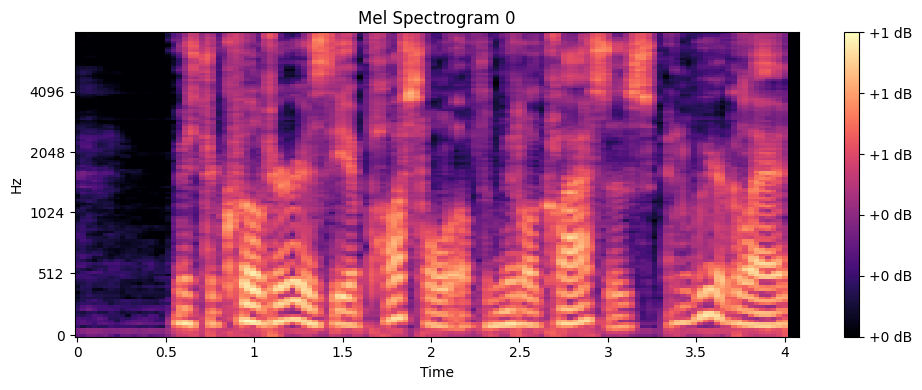

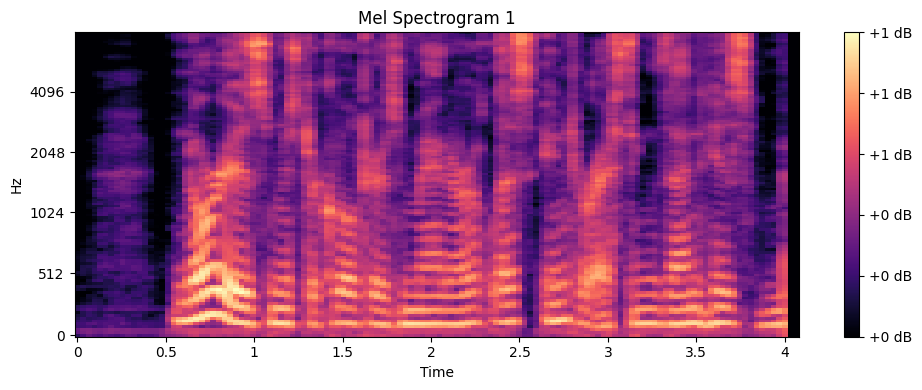

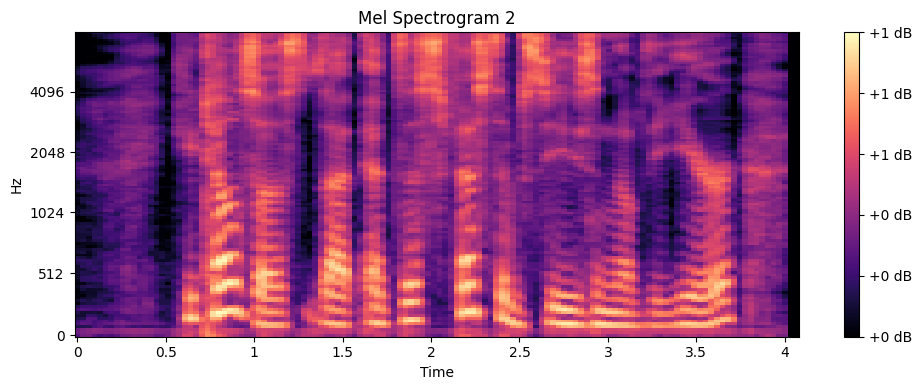

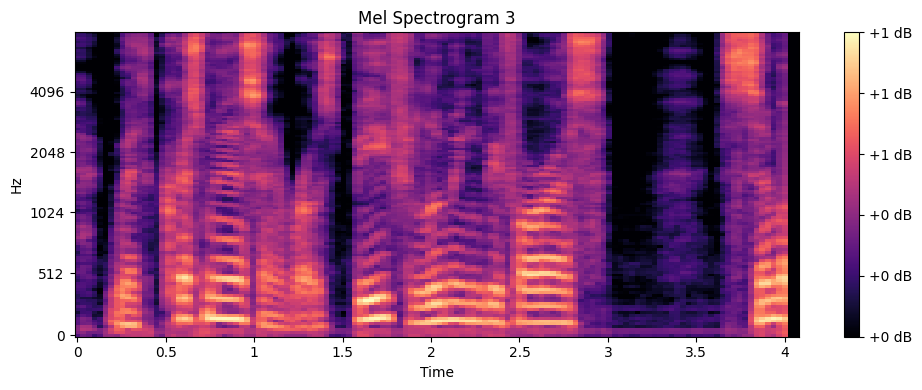

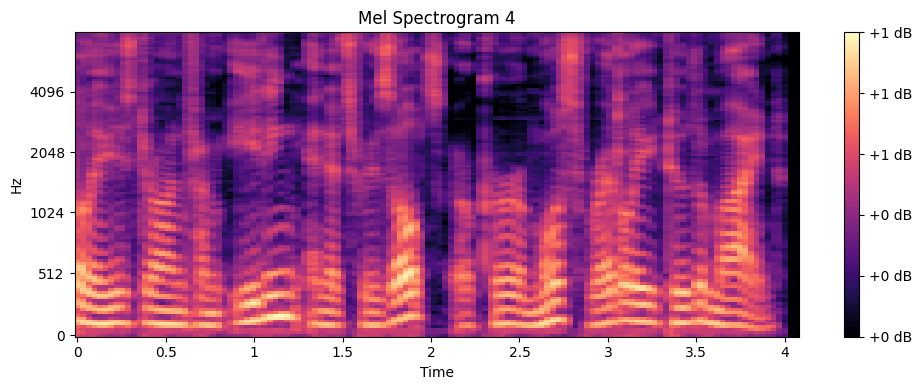

In [3]:

# Adjust the paths based on your setup
data_dir = "data/LibriSpeech/LibriSpeech/dev-clean"
dataset = MelSpectrogramDataset(root_dir=data_dir, target_sr=16000, fragment_duration=1.0, n_fft=2048, hop_length=512, n_mels=128, max_len=128)

# Print dataset statistics and visualize Mel spectrograms
print_dataset_statistics(dataset)
visualize_mel_spectrogram(dataset, num_samples=5)

In [4]:
# visualize_mel_spectrogram(dataset, num_samples=10)

In [5]:
output_dir = "reconstructed_audio"

Reconstructed audio saved to reconstructed_audio/reconstructed_0.wav


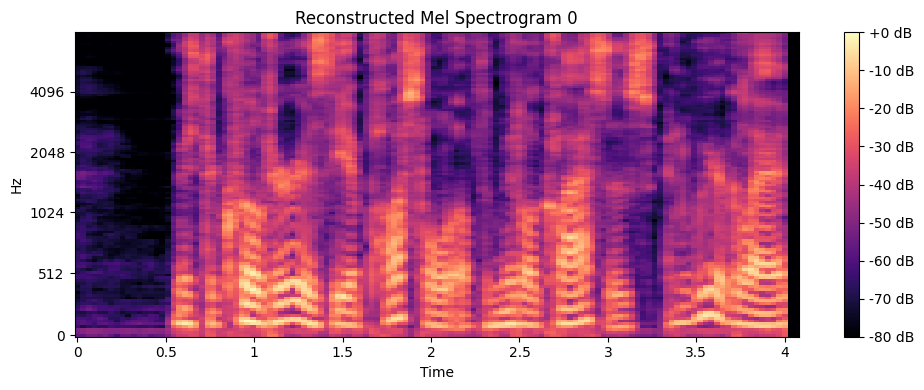

Reconstructed audio saved to reconstructed_audio/reconstructed_1.wav


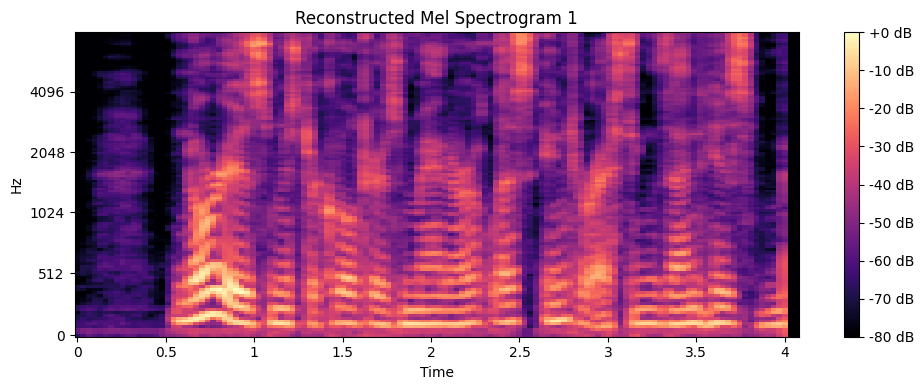

Reconstructed audio saved to reconstructed_audio/reconstructed_2.wav


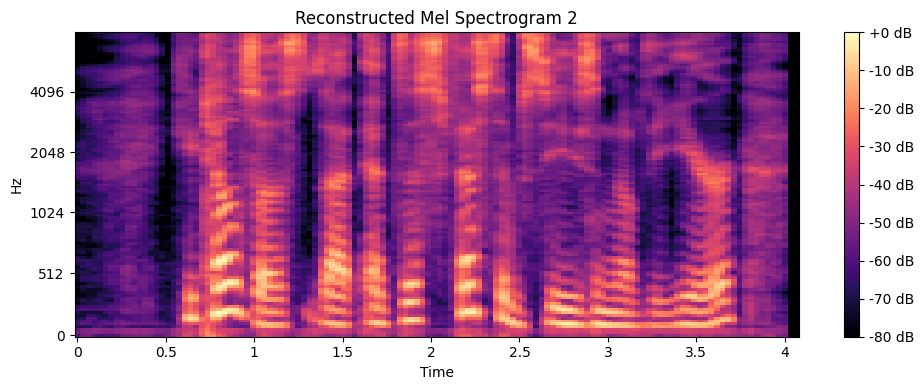

Reconstructed audio saved to reconstructed_audio/reconstructed_3.wav


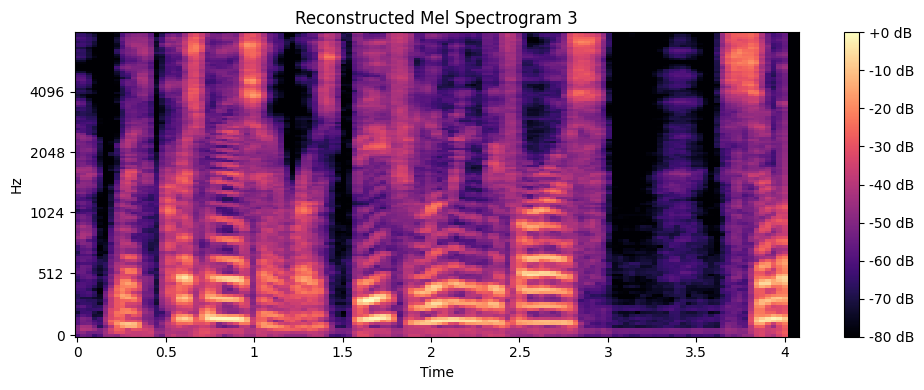

Reconstructed audio saved to reconstructed_audio/reconstructed_4.wav


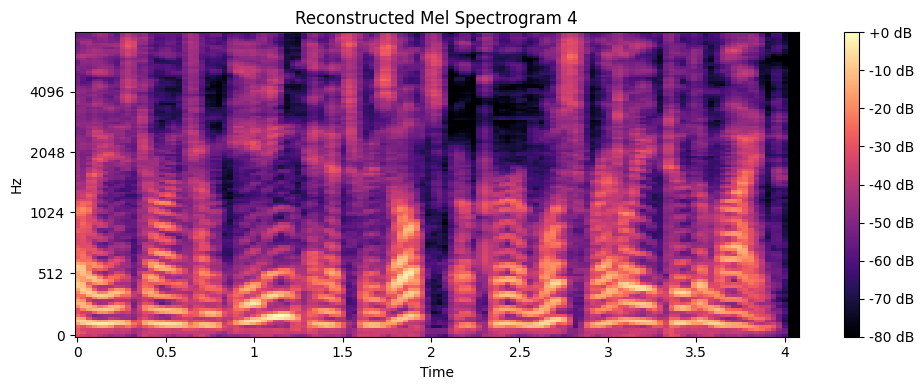

In [6]:
 # Test transforming back to waveform
test_transform_back(dataset, output_dir)

# MODEL1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Turn off the cuDNN auto-tuner to avoid nondeterministic behavior


img_size = 28
img_channels = 1

In [ ]:
# Update these parameters based on your Mel spectrogram dimensions
img_channels = 1
img_height = 128  # n_mels
img_width = 128   # max_len

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, self.img_channels * self.img_height * self.img_width),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x).view(-1, self.img_channels, self.img_height, self.img_width)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.disc = nn.Sequential(
            nn.Linear(self.img_channels * self.img_height * self.img_width, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten input to [batch_size, img_channels * img_height * img_width]
        return self.disc(x.view(-1, self.img_channels * self.img_height * self.img_width))


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.encoder = nn.Sequential(
            nn.Linear(self.img_channels * self.img_height * self.img_width, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512)
        )

    def forward(self, x):
        return self.encoder(x.view(-1, self.img_channels * self.img_height * self.img_width))



In [ ]:

# Function to generate noise for the Generator
def generate_noise(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim).to(device)

# Orthogonal loss function
def orthogonal_loss(feature1, feature2):
    inner_product = torch.sum(feature1 * feature2, dim=1)
    norm1 = torch.norm(feature1, dim=1)
    norm2 = torch.norm(feature2, dim=1)
    cosine_similarity = inner_product / (norm1 * norm2 + 1e-8)
    return torch.mean(cosine_similarity**2)  # Minimize the cosine similarity to make vectors orthogonal
# Loss function
criterion = nn.BCELoss()

In [ ]:
import librosa
import librosa.display
import soundfile as sf
import os

def visualize_generated_mel_spectrograms(generators, z_dim, num_samples, device, epoch, output_dir, target_sr=16000, n_fft=2048, hop_length=512, n_iter=500):
    os.makedirs(output_dir, exist_ok=True)
    noise = generate_noise(num_samples, z_dim, device)
    for idx, gen in enumerate(generators):
        fake_mel_specs = gen(noise).detach().cpu().numpy()  # Shape: [num_samples, 1, n_mels, max_len]
        for i in range(num_samples):
            mel_spec = fake_mel_specs[i][0]  # Remove batch and channel dimensions
            # De-normalize from [-1, 1] back to [0, 1]
            mel_spec = (mel_spec + 1) / 2

            # Convert back to dB scale
            mel_spec_db = mel_spec * 80 - 80  # Assuming min dB is -80

            # Reconstruct audio from Mel spectrogram
            mel_spec_power = librosa.db_to_power(mel_spec_db)
            audio = librosa.feature.inverse.mel_to_audio(
                mel_spec_power,
                sr=target_sr,
                n_fft=n_fft,
                hop_length=hop_length,
                n_iter=n_iter,
                power=1.0,
            )

            # Normalize audio to prevent clipping
            audio = audio / np.max(np.abs(audio)) * 0.99

            # Save reconstructed audio
            audio_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.wav")
            sf.write(audio_filename, audio, target_sr)

            # Save Mel spectrogram image
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec_db, sr=target_sr, hop_length=hop_length, y_axis='mel', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Epoch {epoch} Generator {idx+1} Sample {i+1}')
            plt.tight_layout()
            image_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.png")
            plt.savefig(image_filename)
            plt.close()


In [ ]:
def pretrain_single_generator(num_epochs, z_dim, lr, batch_size, seed, dataset):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the single generator and discriminator
    generator = Generator(z_dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # Use the Mel spectrogram dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Training loop
    for epoch in range(num_epochs):
        loss_disc_epoch = 0
        loss_gen_epoch = 0

        for batch_idx, real in enumerate(train_loader):
            # print(f"--- Epoch {epoch+1}, Batch {batch_idx+1} ---")
            # print(f"Original batch shape: {real.shape}")  # Shape from DataLoader

            real = real.to(device)
            batch_size = real.size(0)
            # print(f"Batch size: {batch_size}")  # Confirm batch size is correct

            # Flatten real before passing to the Discriminator
            real_flattened = real.view(batch_size, -1)  # Flatten to [batch_size, img_channels * img_height * img_width]
            # print(f"Shape after flattening (real_flattened): {real_flattened.shape}")

            # Generate noise and fake images
            noise = generate_noise(batch_size, z_dim, device)
            # print(f"Noise shape: {noise.shape}")  # Should match [batch_size, z_dim]

            fake = generator(noise)
            # print(f"Fake generated shape (before flattening): {fake.shape}")  # Should match [batch_size, 1, 128, 128]

            fake_flattened = fake.view(batch_size, -1)  # Flatten fake to [batch_size, img_channels * img_height * img_width]
            # print(f"Shape after flattening (fake_flattened): {fake_flattened.shape}")

            # Train Discriminator
            disc_real = discriminator(real_flattened).view(-1)
            # print(f"Discriminator output for real samples (disc_real): {disc_real.shape}")  # Should match [batch_size]

            disc_fake = discriminator(fake_flattened.detach()).view(-1)
            # print(f"Discriminator output for fake samples (disc_fake): {disc_fake.shape}")  # Should match [batch_size]

            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()
            # print(f"Loss Discriminator: {loss_disc.item()}")

            # Train Generator
            output = discriminator(fake_flattened).view(-1)
            # print(f"Discriminator output for generator (output): {output.shape}")  # Should match [batch_size]

            loss_gen = criterion(output, torch.ones_like(output))
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            # print(f"Loss Generator: {loss_gen.item()}")

            loss_disc_epoch += loss_disc.item()
            loss_gen_epoch += loss_gen.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_disc_epoch/len(train_loader):.4f}, Loss G: {loss_gen_epoch/len(train_loader):.4f}")
        visualize_generated_mel_spectrograms([generator], z_dim, num_samples=5, device=device, epoch='pretrain', output_dir='pretrain_outputs3')


    # Visualize the generated images after pretraining
    

    return generator


In [ ]:

def initialize_multiple_generators(pretrained_generator, num_generators, z_dim):
    # Initialize multiple generators from the pretrained generator's weights
    generators = []
    for _ in range(num_generators):
        new_generator = Generator(z_dim).to(pretrained_generator.gen[0].weight.device)  # Ensure same device
        new_generator.load_state_dict(pretrained_generator.state_dict())  # Copy weights
        generators.append(new_generator)
    return generators

In [ ]:
def train_gan_with_pretrained_generators(pretrained_generator, num_epochs, z_dim, lr, batch_size, num_generators, seed, dataset, output_dir):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize multiple generators from the pretrained generator
    generators = initialize_multiple_generators(pretrained_generator, num_generators, z_dim)

    # Initialize Discriminator and Encoder
    discriminator = Discriminator().to(device)
    encoder = Encoder().to(device)

    optimizer_gens = [optim.Adam(gen.parameters(), lr=lr) for gen in generators]
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # Use the Mel spectrogram dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Reset loss history
    loss_history_gens = [[] for _ in range(num_generators)]
    loss_history_disc = []

    # Training loop
    for epoch in range(num_epochs):
        loss_disc_epoch = 0
        loss_gens_epoch = [0] * num_generators  # Track each generator's loss

        for batch_idx, real in enumerate(train_loader):  # Changed here
            real = real.to(device)
            batch_size = real.size(0)

            # Train Discriminator
            noise = [generate_noise(batch_size, z_dim, device) for _ in range(num_generators)]
            fakes = [gen(noise[idx]) for idx, gen in enumerate(generators)]

            disc_real = discriminator(real).view(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

            loss_disc_fake_total = 0
            for fake in fakes:
                disc_fake = discriminator(fake.detach()).view(-1)
                loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
                loss_disc_fake_total += loss_disc_fake

            loss_disc = (loss_disc_real + loss_disc_fake_total) / (num_generators + 1)
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generators with Orthogonal Loss
            for idx, gen in enumerate(generators):
                output = discriminator(gen(noise[idx])).view(-1)
                loss_gen = criterion(output, torch.ones_like(output))

                # Compute orthogonal loss with other generators
                gen_feature = encoder(gen(noise[idx]))
                ortho_loss_total = 0
                for other_idx, other_gen in enumerate(generators):
                    if idx != other_idx:
                        other_feature = encoder(other_gen(noise[other_idx]))
                        ortho_loss = orthogonal_loss(gen_feature, other_feature)
                        ortho_loss_total += ortho_loss

                # Combine GAN loss and orthogonal loss
                total_loss_gen = loss_gen + ortho_loss_total / (num_generators - 1)
                optimizer_gens[idx].zero_grad()
                total_loss_gen.backward()
                optimizer_gens[idx].step()

                loss_gens_epoch[idx] += total_loss_gen.item()

        # Store average loss values for the epoch
        loss_history_disc.append(loss_disc_epoch / len(train_loader))
        for idx in range(num_generators):
            loss_history_gens[idx].append(loss_gens_epoch[idx] / len(train_loader))

        # Print losses at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_disc_epoch/len(train_loader):.4f}")
        for idx in range(num_generators):
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss G{idx+1}: {loss_gens_epoch[idx]/len(train_loader):.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Total Loss G: {sum(loss_gens_epoch)/len(train_loader):.4f}")
        print('-' * 50)

        # Visualize and save generated Mel spectrograms and reconstructed audio every 5 epochs
        if (epoch + 1) % 5 == 0:
            visualize_generated_mel_spectrograms(
                generators, z_dim, num_samples=5, device=device,
                epoch=epoch+1, output_dir=output_dir
            )
  
    # Plot loss history
    plt.figure(figsize=(10, 5))
    plt.title("Discriminator Loss")
    plt.plot(loss_history_disc, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    for idx in range(num_generators):
        plt.figure(figsize=(10, 5))
        plt.title(f"Generator {idx+1} Loss")
        plt.plot(loss_history_gens[idx], label=f"Generator {idx+1} Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    # Return the trained generators
    return generators



In [ ]:
pretrained_generator = pretrain_single_generator(
    num_epochs=20,
    z_dim=100,
    lr=0.0002,
    batch_size=64,
    seed=1234,
    dataset=dataset
)


Epoch [1/20] Loss D: 1.0143, Loss G: 1.7019
Epoch [2/20] Loss D: 0.6480, Loss G: 39.9764
Epoch [3/20] Loss D: 0.0000, Loss G: 100.0000
Epoch [4/20] Loss D: 0.0000, Loss G: 100.0000
Epoch [5/20] Loss D: 0.0000, Loss G: 100.0000


KeyboardInterrupt: 

# MODEL2 (Working pretrined code) (Memory Issue)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import librosa
import librosa.display
import soundfile as sf
import os
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Turn off the cuDNN auto-tuner to avoid nondeterministic behavior

# Update these parameters based on your Mel spectrogram dimensions
img_channels = 1
img_height = 128  # n_mels
img_width = 128   # max_len

In [ ]:
# Generator model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, self.img_channels * self.img_height * self.img_width),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x).view(-1, self.img_channels, self.img_height, self.img_width)

# Discriminator model with spectral normalization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.disc = nn.Sequential(
            spectral_norm(nn.Linear(self.img_channels * self.img_height * self.img_width, 4096)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(4096, 2048)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(2048, 1))
        )

    def forward(self, x):
        # Flatten input to [batch_size, img_channels * img_height * img_width]
        x = x.view(-1, self.img_channels * self.img_height * self.img_width)
        return self.disc(x)

# Encoder model for orthogonal vector computation
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.img_channels = img_channels
        self.img_height = img_height
        self.img_width = img_width
        self.encoder = nn.Sequential(
            nn.Linear(self.img_channels * self.img_height * self.img_width, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512)
        )

    def forward(self, x):
        return self.encoder(x.view(-1, self.img_channels * self.img_height * self.img_width))


In [ ]:
# Function to generate noise for the Generator
def generate_noise(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim, device=device)

# Orthogonal loss function
def orthogonal_loss(feature1, feature2):
    inner_product = torch.sum(feature1 * feature2, dim=1)
    norm1 = torch.norm(feature1, dim=1)
    norm2 = torch.norm(feature2, dim=1)
    cosine_similarity = inner_product / (norm1 * norm2 + 1e-8)
    return torch.mean(cosine_similarity**2)  # Minimize the cosine similarity to make vectors orthogonal

# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_pred * y_true)

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device)  # Interpolation factor
    alpha = alpha.expand_as(real_data)  # Expand alpha to match real_data's shape

    # Interpolate between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    # Compute discriminator output for interpolates
    d_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones_like(d_interpolates, device=device)

    # Compute gradients of d_interpolates w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Reshape gradients to [batch_size, -1]
    gradients = gradients.view(batch_size, -1)

    # Compute gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

    return gradient_penalty

import librosa
import librosa.display
import soundfile as sf

In [ ]:
import librosa
import librosa.display
import soundfile as sf
import os
import matplotlib.pyplot as plt

def visualize_generated_mel_spectrograms(generators, z_dim, num_samples, device, epoch, output_dir, target_sr=16000, n_fft=2048, hop_length=512, n_iter=500):
    """
    Visualize and reconstruct audio from generated Mel spectrograms.
    
    Args:
        generators (list): List of trained generator models.
        z_dim (int): Dimensionality of the latent space.
        num_samples (int): Number of samples to generate per generator.
        device (torch.device): Device to run the models on.
        epoch (int): Current training epoch (used for saving files).
        output_dir (str): Directory to save reconstructed audio and spectrogram images.
        target_sr (int): Target sampling rate for audio reconstruction.
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.
        n_iter (int): Number of iterations for Griffin-Lim phase reconstruction.
    """
    os.makedirs(output_dir, exist_ok=True)
    noise = generate_noise(num_samples, z_dim, device)
    
    for idx, gen in enumerate(generators):
        fake_mel_specs = gen(noise).detach().cpu().numpy()  # Shape: [num_samples, 1, n_mels, max_len]
        
        for i in range(num_samples):
            mel_spec = fake_mel_specs[i][0]  # Remove batch and channel dimensions
            # De-normalize from [-1, 1] back to [0, 1]
            mel_spec = (mel_spec + 1) / 2

            # Convert back to dB scale
            mel_spec_db = mel_spec * 80 - 80  # Assuming min dB is -80

            # Convert dB back to power
            mel_spec_power = librosa.db_to_power(mel_spec_db)

            # Reconstruct audio using Griffin-Lim
            audio = librosa.feature.inverse.mel_to_audio(
                mel_spec_power,
                sr=target_sr,
                n_fft=n_fft,
                hop_length=hop_length,
                n_iter=n_iter,
                power=1.0,
            )

            # Normalize audio to prevent clipping
            audio = audio / np.max(np.abs(audio)) * 0.99

            # Save the reconstructed audio to a file
            audio_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.wav")
            sf.write(audio_filename, audio, target_sr)

            print(f"Reconstructed audio saved to {audio_filename}")

            # Save Mel spectrogram image
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec_db, sr=target_sr, hop_length=hop_length, y_axis='mel', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Epoch {epoch} Generator {idx+1} Sample {i+1}')
            plt.tight_layout()
            image_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.png")
            plt.savefig(image_filename)
            plt.close()
            print(f"Mel spectrogram image saved to {image_filename}")


In [ ]:
def pretrain_single_generator(num_epochs, z_dim, lr_gen, lr_disc, batch_size, seed, dataset):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the single generator and discriminator
    generator = Generator(z_dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.9))
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))

    # Use the Mel spectrogram dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Labels for Wasserstein loss
    real_label = -torch.ones(batch_size, 1, device=device)
    fake_label = torch.ones(batch_size, 1, device=device)

    lambda_gp = 10  # Gradient penalty coefficient
    num_critic = 5  # Number of discriminator updates per generator update

    # Training loop
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()  # Clear unused memory
        loss_disc_epoch = 0
        loss_gen_epoch = 0

        for batch_idx, real in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)

            # Adjust labels to match batch size
            real_label = -torch.ones(batch_size, 1, device=device)
            fake_label = torch.ones(batch_size, 1, device=device)

            # Flatten real before passing to the Discriminator
            real_flattened = real.view(batch_size, -1)

            # Generate noise and fake images
            noise = generate_noise(batch_size, z_dim, device)
            fake = generator(noise)
            fake_flattened = fake.view(batch_size, -1)

            # Optional: Add noise to inputs
            real_flattened += 0.001 * torch.randn_like(real_flattened)
            fake_flattened += 0.001 * torch.randn_like(fake_flattened)

            # Train Discriminator multiple times
            for _ in range(num_critic):
                optimizer_disc.zero_grad()

                # Discriminator outputs
                disc_real = discriminator(real_flattened)
                disc_fake = discriminator(fake_flattened.detach())

                # Wasserstein loss with gradient penalty
                loss_disc = wasserstein_loss(disc_real, real_label) + wasserstein_loss(disc_fake, fake_label)
                gradient_penalty = compute_gradient_penalty(discriminator, real_flattened, fake_flattened, device)
                loss_disc += lambda_gp * gradient_penalty

                loss_disc.backward()
                optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generator
            optimizer_gen.zero_grad()
            fake = generator(noise)
            fake_flattened = fake.view(batch_size, -1)
            disc_fake = discriminator(fake_flattened)
            loss_gen = wasserstein_loss(disc_fake, real_label)
            loss_gen.backward()
            optimizer_gen.step()

            loss_gen_epoch += loss_gen.item()

        avg_loss_disc = loss_disc_epoch / len(train_loader)
        avg_loss_gen = loss_gen_epoch / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}, Loss G: {avg_loss_gen:.4f}")

        # Visualize the generated images after each epoch
        visualize_generated_mel_spectrograms([generator], z_dim, num_samples=5, device=device, epoch=epoch+1, output_dir='pretrain_outputs')

    return generator

In [ ]:

def train_gan_with_pretrained_generators(pretrained_generator, num_epochs, z_dim, lr_gen, lr_disc, batch_size, num_generators, seed, dataset, output_dir):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize multiple generators from the pretrained generator
    generators = initialize_multiple_generators(pretrained_generator, num_generators, z_dim)

    # Initialize Discriminator and Encoder
    discriminator = Discriminator().to(device)
    encoder = Encoder().to(device)

    optimizer_gens = [optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.9)) for gen in generators]
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))
    optimizer_encoder = optim.Adam(encoder.parameters(), lr=lr_disc, betas=(0.5, 0.9))  # Optimizer for the encoder

    # Use the Mel spectrogram dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Wasserstein loss labels
    real_label = -torch.ones(batch_size, 1, device=device)
    fake_label = torch.ones(batch_size, 1, device=device)

    lambda_gp = 10  # Gradient penalty coefficient
    num_critic = 5  # Number of discriminator updates per generator update
    lambda_ortho = 1.0  # Weight for the orthogonal loss

    # Training loop
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()  # Clear unused memory
        loss_disc_epoch = 0
        loss_gens_epoch = [0] * num_generators  # Track each generator's loss

        for batch_idx, real in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)

            # Adjust labels to match batch size
            real_label = -torch.ones(batch_size, 1, device=device)
            fake_label = torch.ones(batch_size, 1, device=device)

            # Flatten real before passing to the Discriminator
            real_flattened = real.view(batch_size, -1)

            # Generate noise and fake images for each generator
            noises = [generate_noise(batch_size, z_dim, device) for _ in range(num_generators)]
            fakes = [gen(noises[idx]) for idx, gen in enumerate(generators)]
            fakes_flattened = [fake.view(batch_size, -1) for fake in fakes]

            # Optional: Add noise to inputs
            real_flattened += 0.001 * torch.randn_like(real_flattened)
            for idx in range(num_generators):
                fakes_flattened[idx] += 0.001 * torch.randn_like(fakes_flattened[idx])

            # Train Discriminator multiple times
            for _ in range(num_critic):
                optimizer_disc.zero_grad()

                # Discriminator outputs for real data
                disc_real = discriminator(real_flattened)

                # Discriminator outputs for fake data from all generators
                disc_fakes = [discriminator(fake_flattened.detach()) for fake_flattened in fakes_flattened]

                # Wasserstein loss with gradient penalty
                loss_disc = wasserstein_loss(disc_real, real_label)
                for disc_fake in disc_fakes:
                    loss_disc += wasserstein_loss(disc_fake, fake_label)

                # Compute gradient penalties for each fake data
                gradient_penalty = 0
                for fake_flattened in fakes_flattened:
                    gradient_penalty += compute_gradient_penalty(discriminator, real_flattened, fake_flattened, device)

                loss_disc += lambda_gp * gradient_penalty / num_generators  # Average gradient penalty

                loss_disc.backward()
                optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generators with Orthogonal Loss
            for idx, gen in enumerate(generators):
                optimizer_gens[idx].zero_grad()
                optimizer_encoder.zero_grad()

                noise = generate_noise(batch_size, z_dim, device)
                fake = gen(noise)
                fake_flattened = fake.view(batch_size, -1)
                disc_fake = discriminator(fake_flattened)

                # Wasserstein loss for generator
                loss_gen = wasserstein_loss(disc_fake, real_label)

                # Compute orthogonal loss with other generators
                gen_feature = encoder(fake_flattened)
                ortho_loss_total = 0
                for other_idx, other_gen in enumerate(generators):
                    if idx != other_idx:
                        other_fake = other_gen(noise)
                        other_fake_flattened = other_fake.view(batch_size, -1)
                        other_feature = encoder(other_fake_flattened)
                        ortho_loss = orthogonal_loss(gen_feature, other_feature)
                        ortho_loss_total += ortho_loss

                # Average orthogonal loss
                if num_generators > 1:
                    ortho_loss_total = ortho_loss_total / (num_generators - 1)
                else:
                    ortho_loss_total = 0

                # Total generator loss
                total_loss_gen = loss_gen + lambda_ortho * ortho_loss_total

                total_loss_gen.backward()
                optimizer_gens[idx].step()
                optimizer_encoder.step()  # Update the encoder

                loss_gens_epoch[idx] += total_loss_gen.item()

        # Calculate average losses
        avg_loss_disc = loss_disc_epoch / len(train_loader)
        avg_loss_gens = [loss / len(train_loader) for loss in loss_gens_epoch]

        # Print losses at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}")
        for idx in range(num_generators):
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss G{idx+1}: {avg_loss_gens[idx]:.4f}")
        print('-' * 50)

        # Visualize and save generated Mel spectrograms and reconstructed audio every epoch
        visualize_generated_mel_spectrograms(
            generators, z_dim, num_samples=5, device=device,
            epoch=epoch+1, output_dir=output_dir
        )

    # Return the trained generators
    return generators


In [ ]:
def initialize_multiple_generators(pretrained_generator, num_generators, z_dim):
    # Initialize multiple generators from the pretrained generator's weights
    generators = []
    for _ in range(num_generators):
        new_generator = Generator(z_dim).to(pretrained_generator.gen[0].weight.device)  # Ensure same device
        new_generator.load_state_dict(pretrained_generator.state_dict())  # Copy weights
        generators.append(new_generator)
    return generators


In [ ]:
pretrained_generator = pretrain_single_generator(
    num_epochs=20,
    z_dim=100,
    lr_gen=0.0001,
    lr_disc=0.0004,
    batch_size=64,
    seed=1234,
    dataset=dataset
)


Epoch [1/3] Loss D: -6.4929, Loss G: 2.0177
Reconstructed audio saved to pretrain_outputs/epoch1_gen1_sample1.wav
Mel spectrogram image saved to pretrain_outputs/epoch1_gen1_sample1.png
Reconstructed audio saved to pretrain_outputs/epoch1_gen1_sample2.wav
Mel spectrogram image saved to pretrain_outputs/epoch1_gen1_sample2.png
Reconstructed audio saved to pretrain_outputs/epoch1_gen1_sample3.wav
Mel spectrogram image saved to pretrain_outputs/epoch1_gen1_sample3.png
Reconstructed audio saved to pretrain_outputs/epoch1_gen1_sample4.wav
Mel spectrogram image saved to pretrain_outputs/epoch1_gen1_sample4.png
Reconstructed audio saved to pretrain_outputs/epoch1_gen1_sample5.wav
Mel spectrogram image saved to pretrain_outputs/epoch1_gen1_sample5.png
Epoch [2/3] Loss D: -5.4143, Loss G: 3.5130
Reconstructed audio saved to pretrain_outputs/epoch2_gen1_sample1.wav
Mel spectrogram image saved to pretrain_outputs/epoch2_gen1_sample1.png
Reconstructed audio saved to pretrain_outputs/epoch2_gen1_sa

In [ ]:
# Train GAN with multiple generators
trained_generators = train_gan_with_pretrained_generators(
    pretrained_generator=pretrained_generator,
    num_epochs=80,
    z_dim=100,
    lr_gen=0.0001,
    lr_disc=0.0004,
    batch_size=8,
    num_generators=2,
    seed=1234,
    dataset=dataset,
    output_dir='multi_gen_outputs'
)

NameError: name 'initialize_multiple_generators' is not defined

# CLEAR CUDA MEM

In [18]:
import torch

# Clear unused CUDA memory
torch.cuda.empty_cache()


# MODEL3

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import librosa
import librosa.display
import soundfile as sf
import os
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Turn off the cuDNN auto-tuner to avoid nondeterministic behavior

# Update these parameters based on your Mel spectrogram dimensions
img_channels = 1
img_height = 128  # n_mels
img_width = 128   # max_len

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.init_size = 8  # Output of the initial linear layer is 8x8
        self.l1 = nn.Sequential(nn.Linear(z_dim, 512 * self.init_size ** 2))
        self.model = nn.Sequential(
            # Input: [batch_size, 512, 8, 8]
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),  # [512, 16, 16]
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),  # [256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # [256, 32, 32]
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # [128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # [128, 64, 64]
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # [64, 64, 64]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # [64, 128, 128]
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),  # [1, 128, 128]
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 512, self.init_size, self.init_size)
        img = self.model(out)
        return img

import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: [batch_size, 1, 128, 128]
            spectral_norm(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),  # [64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),  # [128, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),  # [256, 16, 16]
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),  # [512, 8, 8]
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.adv_layer = spectral_norm(nn.Linear(512 * 8 * 8, 1))

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity


# Encoder model for orthogonal vector computation
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            # Input: [batch_size, 1, 128, 128]
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # [64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [128, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [256, 16, 16]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # [512, 8, 8]
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(512 * 8 * 8, 512)

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        features = self.fc(out)
        return features


In [9]:
# Function to generate noise for the Generator
def generate_noise(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim, device=device)

# Orthogonal loss function
def orthogonal_loss(feature1, feature2):
    inner_product = torch.sum(feature1 * feature2, dim=1)
    norm1 = torch.norm(feature1, dim=1)
    norm2 = torch.norm(feature2, dim=1)
    cosine_similarity = inner_product / (norm1 * norm2 + 1e-8)
    return torch.mean(cosine_similarity**2)  # Minimize the cosine similarity to make vectors orthogonal

# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_pred * y_true)

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)  # Interpolation factor
    epsilon = epsilon.expand_as(real_data)

    # Interpolate between real and fake data
    interpolates = epsilon * real_data + (1 - epsilon) * fake_data
    interpolates = interpolates.requires_grad_(True)

    # Compute discriminator output for interpolates
    d_interpolates = discriminator(interpolates)
    grad_outputs = torch.ones_like(d_interpolates, device=device)

    # Compute gradients of d_interpolates w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Reshape gradients to [batch_size, -1]
    gradients = gradients.view(batch_size, -1)

    # Compute gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


import librosa
import librosa.display
import soundfile as sf

In [10]:
import librosa
import librosa.display
import soundfile as sf
import os
import matplotlib.pyplot as plt

def visualize_generated_mel_spectrograms(generators, z_dim, num_samples, device, epoch, output_dir, target_sr=16000, n_fft=2048, hop_length=512, n_iter=500):
    """
    Visualize and reconstruct audio from generated Mel spectrograms.
    
    Args:
        generators (list): List of trained generator models.
        z_dim (int): Dimensionality of the latent space.
        num_samples (int): Number of samples to generate per generator.
        device (torch.device): Device to run the models on.
        epoch (int): Current training epoch (used for saving files).
        output_dir (str): Directory to save reconstructed audio and spectrogram images.
        target_sr (int): Target sampling rate for audio reconstruction.
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.
        n_iter (int): Number of iterations for Griffin-Lim phase reconstruction.
    """
    os.makedirs(output_dir, exist_ok=True)
    noise = generate_noise(num_samples, z_dim, device)
    
    for idx, gen in enumerate(generators):
        fake_mel_specs = gen(noise).detach().cpu().numpy()  # Shape: [num_samples, 1, n_mels, max_len]
        
        for i in range(num_samples):
            mel_spec = fake_mel_specs[i][0]  # Remove batch and channel dimensions
            # De-normalize from [-1, 1] back to [0, 1]
            mel_spec = (mel_spec + 1) / 2

            # Convert back to dB scale
            mel_spec_db = mel_spec * 80 - 80  # Assuming min dB is -80

            # Convert dB back to power
            mel_spec_power = librosa.db_to_power(mel_spec_db)

            # Reconstruct audio using Griffin-Lim
            audio = librosa.feature.inverse.mel_to_audio(
                mel_spec_power,
                sr=target_sr,
                n_fft=n_fft,
                hop_length=hop_length,
                n_iter=n_iter,
                power=1.0,
            )

            # Normalize audio to prevent clipping
            audio = audio / np.max(np.abs(audio)) * 0.99

            # Save the reconstructed audio to a file
            audio_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.wav")
            sf.write(audio_filename, audio, target_sr)

            print(f"Reconstructed audio saved to {audio_filename}")

            # Save Mel spectrogram image
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec_db, sr=target_sr, hop_length=hop_length, y_axis='mel', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Epoch {epoch} Generator {idx+1} Sample {i+1}')
            plt.tight_layout()
            image_filename = os.path.join(output_dir, f"epoch{epoch}_gen{idx+1}_sample{i+1}.png")
            plt.savefig(image_filename)
            plt.close()
            print(f"Mel spectrogram image saved to {image_filename}")


In [16]:
def train_gan_with_pretrained_generators(
    pretrained_generator, num_epochs, z_dim, lr_gen, lr_disc, batch_size,
    num_generators, seed, dataset, output_dir, lambda_ortho=0.1
):
    # Set the seed for reproducibility
    set_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize multiple generators
    generators = initialize_multiple_generators(pretrained_generator, num_generators, z_dim)

    # Initialize Discriminator
    discriminator = Discriminator().to(device)

    optimizer_gens = [optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.9)) for gen in generators]
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))

    # Initialize Encoder only if lambda_ortho > 0
    if lambda_ortho > 0:
        encoder = Encoder().to(device)
        optimizer_encoder = optim.Adam(encoder.parameters(), lr=lr_disc, betas=(0.5, 0.9))
    else:
        encoder = None
        optimizer_encoder = None

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    lambda_gp = 10
    num_critic = 5

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        loss_disc_epoch = 0
        loss_gens_epoch = [0] * num_generators

        for batch_idx, real in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)

            real_label = -torch.ones(batch_size, 1, device=device)
            fake_label = torch.ones(batch_size, 1, device=device)

            real = real + 0.001 * torch.randn_like(real)

            # Train Discriminator
            for _ in range(num_critic):
                optimizer_disc.zero_grad()

                disc_real = discriminator(real)

                noises = [generate_noise(batch_size, z_dim, device) for _ in range(num_generators)]
                fakes = [gen(noises[idx]).detach() for idx, gen in enumerate(generators)]

                for idx in range(num_generators):
                    fakes[idx] = fakes[idx] + 0.001 * torch.randn_like(fakes[idx])

                disc_fakes = [discriminator(fake) for fake in fakes]

                # Average the fake losses
                loss_disc_fake = sum(wasserstein_loss(disc_fake, fake_label) for disc_fake in disc_fakes) / num_generators
                loss_disc_real = wasserstein_loss(disc_real, real_label)
                loss_disc = loss_disc_real + loss_disc_fake

                # Average gradient penalty
                gradient_penalty = sum(compute_gradient_penalty(discriminator, real, fake, device) for fake in fakes) / num_generators
                loss_disc += lambda_gp * gradient_penalty

                loss_disc.backward()
                optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generators
            for idx, gen in enumerate(generators):
                optimizer_gens[idx].zero_grad()
                if lambda_ortho > 0:
                    optimizer_encoder.zero_grad()

                noise = generate_noise(batch_size, z_dim, device)
                fake = gen(noise)
                disc_fake = discriminator(fake)

                loss_gen = wasserstein_loss(disc_fake, real_label)

                if lambda_ortho > 0:
                    # Compute orthogonal loss
                    gen_feature = encoder(fake)
                    ortho_loss_total = 0
                    for other_idx, other_gen in enumerate(generators):
                        if idx != other_idx:
                            other_noise = generate_noise(batch_size, z_dim, device)
                            other_fake = other_gen(other_noise)
                            other_feature = encoder(other_fake)
                            ortho_loss = orthogonal_loss(gen_feature, other_feature)
                            ortho_loss_total += ortho_loss

                    ortho_loss_total /= (num_generators - 1)
                    total_loss_gen = loss_gen + lambda_ortho * ortho_loss_total
                else:
                    total_loss_gen = loss_gen

                total_loss_gen.backward()
                optimizer_gens[idx].step()

                if lambda_ortho > 0:
                    optimizer_encoder.step()

                loss_gens_epoch[idx] += total_loss_gen.item()

        avg_loss_disc = loss_disc_epoch / len(train_loader)
        avg_loss_gens = [loss / len(train_loader) for loss in loss_gens_epoch]

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}")
        for idx in range(num_generators):
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss G{idx+1}: {avg_loss_gens[idx]:.4f}")
        print('-' * 50)

        visualize_generated_mel_spectrograms(
            generators, z_dim, num_samples=5, device=device,
            epoch=epoch+1, output_dir=output_dir
        )

    return generators


In [ ]:
import matplotlib.pyplot as plt

def pretrain_single_generator(num_epochs, z_dim, lr_gen, lr_disc, batch_size, seed, dataset, output_dir):
    # Set the seed for reproducibility
    set_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the single generator and discriminator
    generator = Generator(z_dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.9))
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))

    # Use the Mel spectrogram dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    lambda_gp = 10  # Gradient penalty coefficient
    num_critic = 5  # Number of discriminator updates per generator update

    # To track the losses
    loss_disc_history = []
    loss_gen_history = []

    # Training loop
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()  # Clear unused memory
        loss_disc_epoch = 0
        loss_gen_epoch = 0

        for batch_idx, real in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)

            # Adjust labels to match batch size and discriminator output shape
            real_label = -torch.ones(batch_size, 1, device=device)
            fake_label = torch.ones(batch_size, 1, device=device)

            # Generate noise and fake images
            noise = generate_noise(batch_size, z_dim, device)
            fake = generator(noise)

            # Optional: Add noise to inputs (use out-of-place operations)
            real = real + 0.001 * torch.randn_like(real)
            fake = fake + 0.001 * torch.randn_like(fake)

            # Train Discriminator multiple times
            for _ in range(num_critic):
                optimizer_disc.zero_grad()

                # Discriminator outputs
                disc_real = discriminator(real)
                disc_fake = discriminator(fake.detach())

                # Wasserstein loss with gradient penalty
                loss_disc = wasserstein_loss(disc_real, real_label) + wasserstein_loss(disc_fake, fake_label)
                gradient_penalty = compute_gradient_penalty(discriminator, real, fake.detach(), device)
                loss_disc += lambda_gp * gradient_penalty

                loss_disc.backward()
                optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generator
            optimizer_gen.zero_grad()
            fake = generator(noise)
            disc_fake = discriminator(fake)
            loss_gen = wasserstein_loss(disc_fake, real_label)
            loss_gen.backward()
            optimizer_gen.step()

            loss_gen_epoch += loss_gen.item()

        avg_loss_disc = loss_disc_epoch / len(train_loader)
        avg_loss_gen = loss_gen_epoch / len(train_loader)

        # Record the losses
        loss_disc_history.append(avg_loss_disc)
        loss_gen_history.append(avg_loss_gen)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}, Loss G: {avg_loss_gen:.4f}")

        # Visualize the generated images after each epoch
        visualize_generated_mel_spectrograms([generator], z_dim, num_samples=5, device=device, epoch=epoch+1, output_dir=output_dir)

    # Save the generator model
    torch.save(generator.state_dict(), os.path.join(output_dir, "pretrained_generator.pth"))
    print(f"Pretrained generator model saved to {os.path.join(output_dir, 'pretrained_generator.pth')}")

    # Plot the learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(loss_disc_history, label="Discriminator Loss")
    plt.plot(loss_gen_history, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "learning_curves.png"))
    plt.show()

    return generator


In [13]:
def load_pretrained_generator(z_dim, weight_path, device):
    """
    Load the pretrained generator model weights.

    Args:
        z_dim (int): Latent space dimension.
        weight_path (str): Path to the saved model weights.
        device (torch.device): Device to load the model onto.

    Returns:
        Generator: Loaded generator model.
    """
    generator = Generator(z_dim).to(device)
    generator.load_state_dict(torch.load(weight_path, map_location=device))
    generator.eval()  # Set the model to evaluation mode
    print(f"Pretrained generator model loaded from {weight_path}")
    return generator


In [14]:
def initialize_multiple_generators(pretrained_generator, num_generators, z_dim):
    # Get the device from the pretrained_generator's parameters
    device = next(pretrained_generator.parameters()).device
    
    generators = []
    for _ in range(num_generators):
        # Ensure the new generator is on the same device
        new_generator = Generator(z_dim).to(device)
        # Copy weights from the pretrained generator
        new_generator.load_state_dict(pretrained_generator.state_dict())
        generators.append(new_generator)
    return generators


In [15]:

pretrained_generator = pretrain_single_generator(
    num_epochs=100,
    z_dim=100,
    lr_gen=0.0001,
    lr_disc=0.0004,
    batch_size=64,
    seed=1234,
    dataset=dataset,
    output_dir = 'pretrain_outputsCNN'
)


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] Loss D: -25.5381, Loss G: -109.7909
Reconstructed audio saved to pretrain_outputsCNN/epoch1_gen1_sample1.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch1_gen1_sample1.png
Reconstructed audio saved to pretrain_outputsCNN/epoch1_gen1_sample2.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch1_gen1_sample2.png
Reconstructed audio saved to pretrain_outputsCNN/epoch1_gen1_sample3.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch1_gen1_sample3.png
Reconstructed audio saved to pretrain_outputsCNN/epoch1_gen1_sample4.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch1_gen1_sample4.png
Reconstructed audio saved to pretrain_outputsCNN/epoch1_gen1_sample5.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch1_gen1_sample5.png
Epoch [2/100] Loss D: -5.2463, Loss G: -132.0646
Reconstructed audio saved to pretrain_outputsCNN/epoch2_gen1_sample1.wav
Mel spectrogram image saved to pretrain_outputsCNN/epoch2_gen1_sample1.png
Reconstructed

In [ ]:
pretrained_generator = load_pretrained_generator(
    z_dim=100,
    weight_path='pretrain_outputsCNN/pretrained_generator.pth',  # Path to saved weights
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)


In [17]:

trained_generators = train_gan_with_pretrained_generators(
    pretrained_generator=pretrained_generator,
    num_epochs=80,
    z_dim=100,
    lr_gen=0.0001,
    lr_disc=0.0004,
    batch_size=8,
    num_generators=2,
    seed=1234,
    dataset=dataset,
    output_dir='multi_gen_outputs_CNN',
    lambda_ortho=0.05  # Adjusted value for lambda_ortho
)


Epoch [1/80] Loss D: -4.2359
Epoch [1/80] Loss G1: -13.6368
Epoch [1/80] Loss G2: -13.6131
--------------------------------------------------
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen1_sample1.wav
Mel spectrogram image saved to multi_gen_outputs_CNN/epoch1_gen1_sample1.png
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen1_sample2.wav
Mel spectrogram image saved to multi_gen_outputs_CNN/epoch1_gen1_sample2.png
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen1_sample3.wav
Mel spectrogram image saved to multi_gen_outputs_CNN/epoch1_gen1_sample3.png
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen1_sample4.wav
Mel spectrogram image saved to multi_gen_outputs_CNN/epoch1_gen1_sample4.png
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen1_sample5.wav
Mel spectrogram image saved to multi_gen_outputs_CNN/epoch1_gen1_sample5.png
Reconstructed audio saved to multi_gen_outputs_CNN/epoch1_gen2_sample1.wav
Mel spectrogram image s